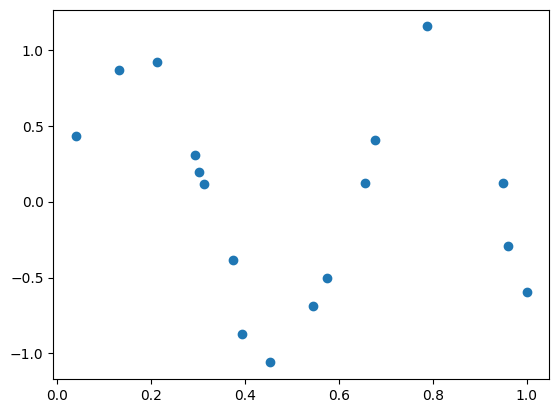

In [1]:
from data_utils import generate_data_from_function
import numpy as np
import matplotlib.pyplot as plt
import torch

# Generate dataset
T, X = generate_data_from_function(lambda x: np.sin(10 * x), num_samples=500, sparsity=0.2)
time_values = np.linspace(0, 1, T.shape[1])

plt.plot(T[0], X[0], "o")
plt.show()

In [9]:
from neuralint import NeuralInt
from data_utils import get_dataloaders
from model_utils import load_model, train

dataloaders = get_dataloaders(T, X)
model = NeuralInt(input_dim=X.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-8)
epoch, loss = load_model(model, optimizer=optimizer)
train(model, optimizer, dataloaders["train"], dataloaders["validate"], num_epochs=100, starting_epoch = epoch, best_val_loss = loss)

Starting training at epoch 11/100, Validation Loss: 0.0047262
Epoch 11/100, Training Loss: 0.0215712
Checkpoint saved: checkpoints\checkpoint_epoch_11.pth
Epoch 11/100, Validation Loss: 0.0036163
Best model saved: checkpoints\best_model.pth


KeyboardInterrupt: 

In [10]:
from neuralint import get_imputation_from_checkpoint
import matplotlib.pyplot as plt

subset = dataloaders["test"].dataset
T_test, X_test, _ = subset.dataset[subset.indices]

X_imputed_transformer, X_imputed_neuralint, integration_fn = get_imputation_from_checkpoint(T_test, X_test)

Loaded model checkpoint with epoch: 10, and validation loss: 0.0036162734031677246


In [11]:
X_imputed_mean_neuralint = torch.mean(X_imputed_neuralint, axis=0).detach().numpy()
X_imputed_mean_transformer = torch.mean(X_imputed_transformer, axis=0).detach().numpy()

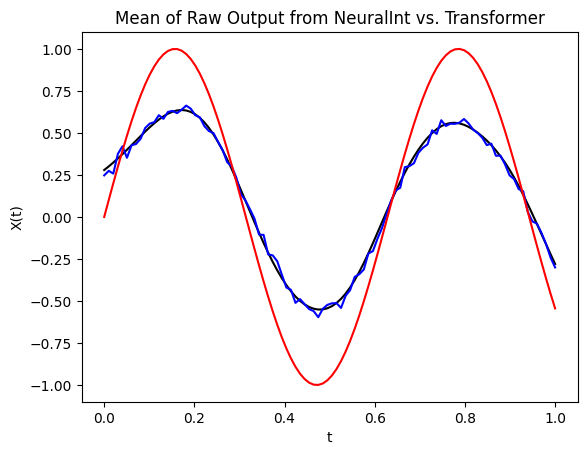

In [12]:
plt.plot(time_values, X_imputed_mean_neuralint, color="black", label="NeuralInt")
plt.plot(time_values, X_imputed_mean_transformer, color="blue", label="Transformer", )
plt.plot(time_values, np.sin(10 * time_values), color="red", label="Transformer")
plt.xlabel('t')
plt.ylabel('X(t)')
plt.title('Mean of Raw Output from NeuralInt vs. Transformer')
plt.show()

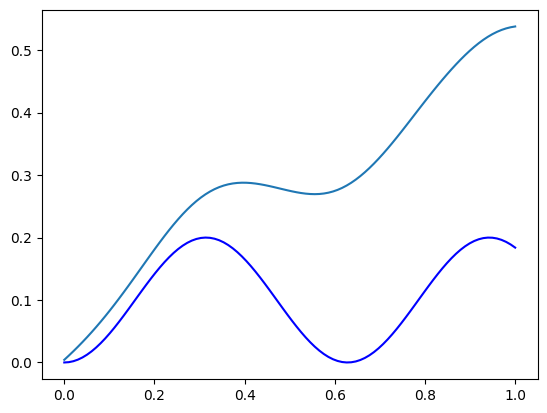

In [14]:
from experiment_utils import trapezoid_rule_weights


plt.plot(time_values, integration_fn[0].detach().numpy())
plt.plot(time_values, 1/5 * np.sin(5 * time_values)**2, color="blue")
plt.show()